# Reference: [Python for Algorithmic Trading (Yves Hilpisch, pp.107-113)](oreilly.com/library/view/python-for-algorithmic/9781492053347/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

# Strategies Based on Mean Reversion

This strategy refers to the tendency of of an asset price to "revert" towards some "trend path".<br>
Using a simple moving average (SMA) as this trend path, if the price strays too high above the path, the asset is shorted and vice versa.



## Reading the data

In [2]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()
raw

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.0000,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.6500,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5000,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.9000,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.1000,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,284.270000,157.380,59.41,1789.21,229.91,321.23,3223.38,12.67,1.1087,1498.8100,28.66,141.27
2019-12-26,289.910000,158.670,59.82,1868.77,231.21,322.94,3239.91,12.65,1.1096,1511.2979,29.08,142.38
2019-12-27,289.800000,158.960,60.08,1869.80,230.66,322.86,3240.02,13.43,1.1175,1510.4167,28.87,142.33


## Set up basic position and returns


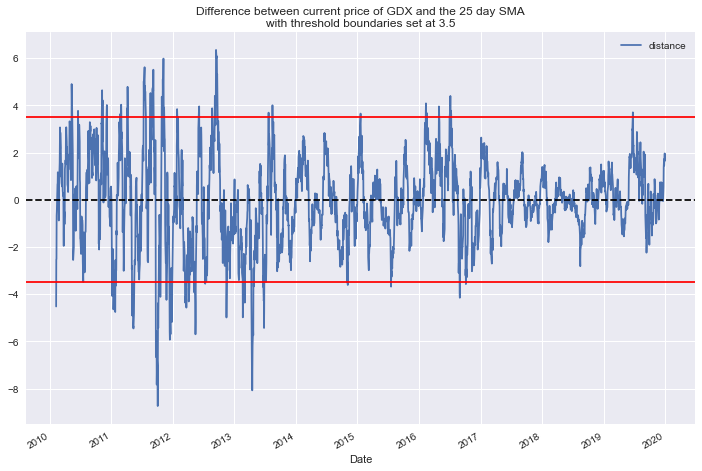

In [3]:
plt.style.use('seaborn')

tick = 'GDX'
sma = 25
threshold = 3.5

data = raw[[tick]].rename(columns={tick: 'price'})
data['returns'] = np.log(data['price'] / data['price'].shift())
data['sma'] = data['price'].rolling(sma).mean()
data['distance'] = data['price'] - data['sma']
(data['distance'].dropna()
 .plot(figsize=(12, 8),
       legend=True,
       title=f'Difference between current price of GDX and the {sma} day SMA\n'
             f'with threshold boundaries set at {threshold}'))

plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.axhline(0, color='k', linestyle='--')


## Set up positioning

<AxesSubplot:title={'center':'Positionings generated for GDX based on mean reversion strategy.'}, xlabel='Date'>

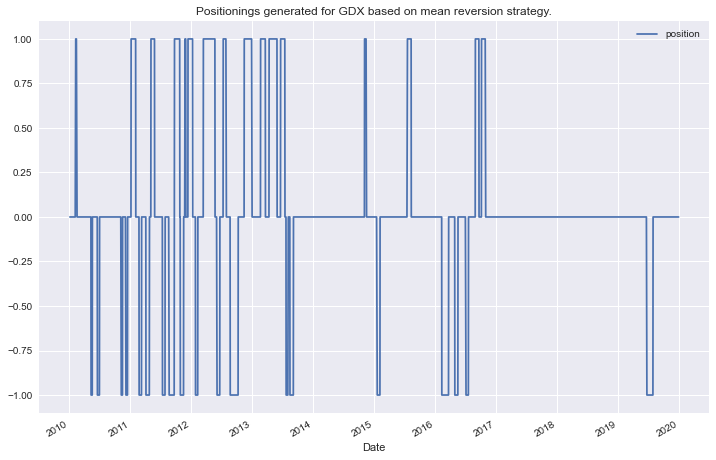

In [4]:
data['position'] = np.where(data['distance'] > threshold, -1, np.nan)
data['position'] = np.where(data['distance'] < -threshold, 1, data['position'])
data['position'] = np.where(data['distance'] * data['distance'].shift(1) < 0, 0, data['position'])
data['position'] = data['position'].ffill().fillna(0)

(data['position'].dropna()
 .plot(figsize=(12, 8),
       legend=True,
       title='Positionings generated for GDX based on mean reversion strategy.'))

## Calculate returns

<AxesSubplot:title={'center':'Gross performance of GDX ETF and the mean-reversion strategy\n(with 25 day SMA and threshold of 3.5)'}, xlabel='Date'>

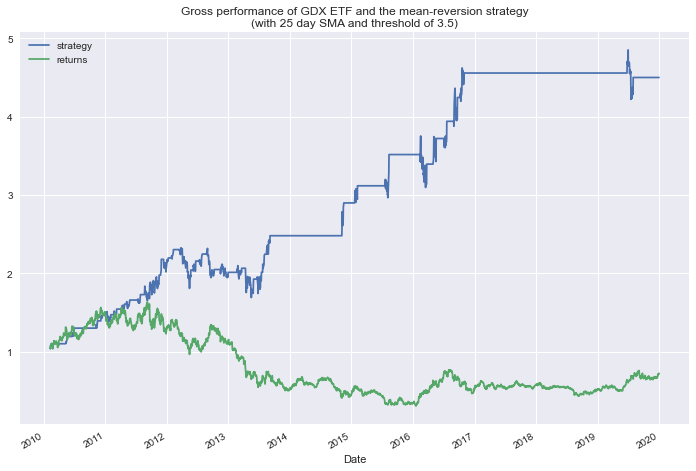

In [5]:
data['strategy'] = data['position'].shift() * data['returns']
(data[['strategy', 'returns']].iloc[sma:]
 .cumsum()
 .apply(np.exp)
 .plot(figsize=(12, 8),
       legend=True,
       title='Gross performance of GDX ETF and the mean-reversion strategy\n'
            f'(with {sma} day SMA and threshold of {threshold})'))